In [30]:
import meteostat
from datetime import datetime 

maine_stations = meteostat.Stations().region("US", "ME").fetch().sort_values(by=["daily_start"])
maine_stations = maine_stations[maine_stations["daily_start"] < maine_stations["daily_start"].mean()]
print(maine_stations[["name", "daily_start", "daily_end"]])

# Determine the maximum year range:
start_year = min([datetime.fromisoformat(str(df["daily_start"])).year for _, df in maine_stations.iterrows()])
end_year = max([datetime.fromisoformat(str(df["daily_end"])).year for _, df in maine_stations.iterrows()])

                                      name daily_start  daily_end
id                                                               
72608                             Eastport  1889-09-01 2013-04-19
72619                           Greenville  1920-01-01 2024-11-11
72712            Caribou Municipal Airport  1939-01-16 2024-12-30
74392              Brunswick Naval Air Stn  1940-09-01 2010-02-07
72606      Portland International  Jetport  1940-11-07 2024-12-30
72713                         Presque Isle  1941-11-02 2022-04-25
KMLT0           Millinocket / Little Italy  1943-03-02 2022-04-24
72607  Bangor / Martells Mobile Home Court  1953-01-01 2024-12-30
KAUG0                              Augusta  1973-01-01 2022-04-24


# Heating Degree Days (HDD)

Heating Degree Days (HDD) is a metric used to quantify the energy demand for heating buildings. It is calculated by subtracting the average daily temperature from a base temperature, typically 65°F (18°C). If the resulting difference is positive, it indicates a heating demand, and the value is added to the cumulative HDD for that period. A higher HDD value signifies colder weather and increased energy consumption for heating. HDD data is valuable for various applications including energy forecasting and building energy efficiency analysis.

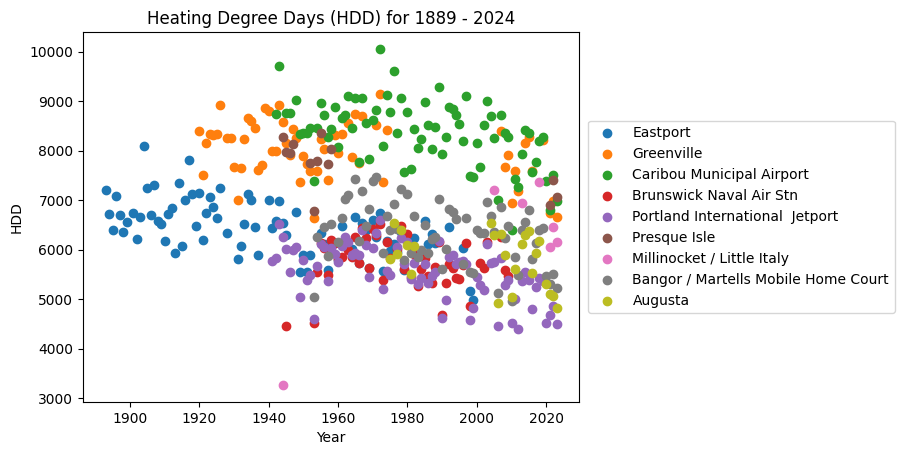

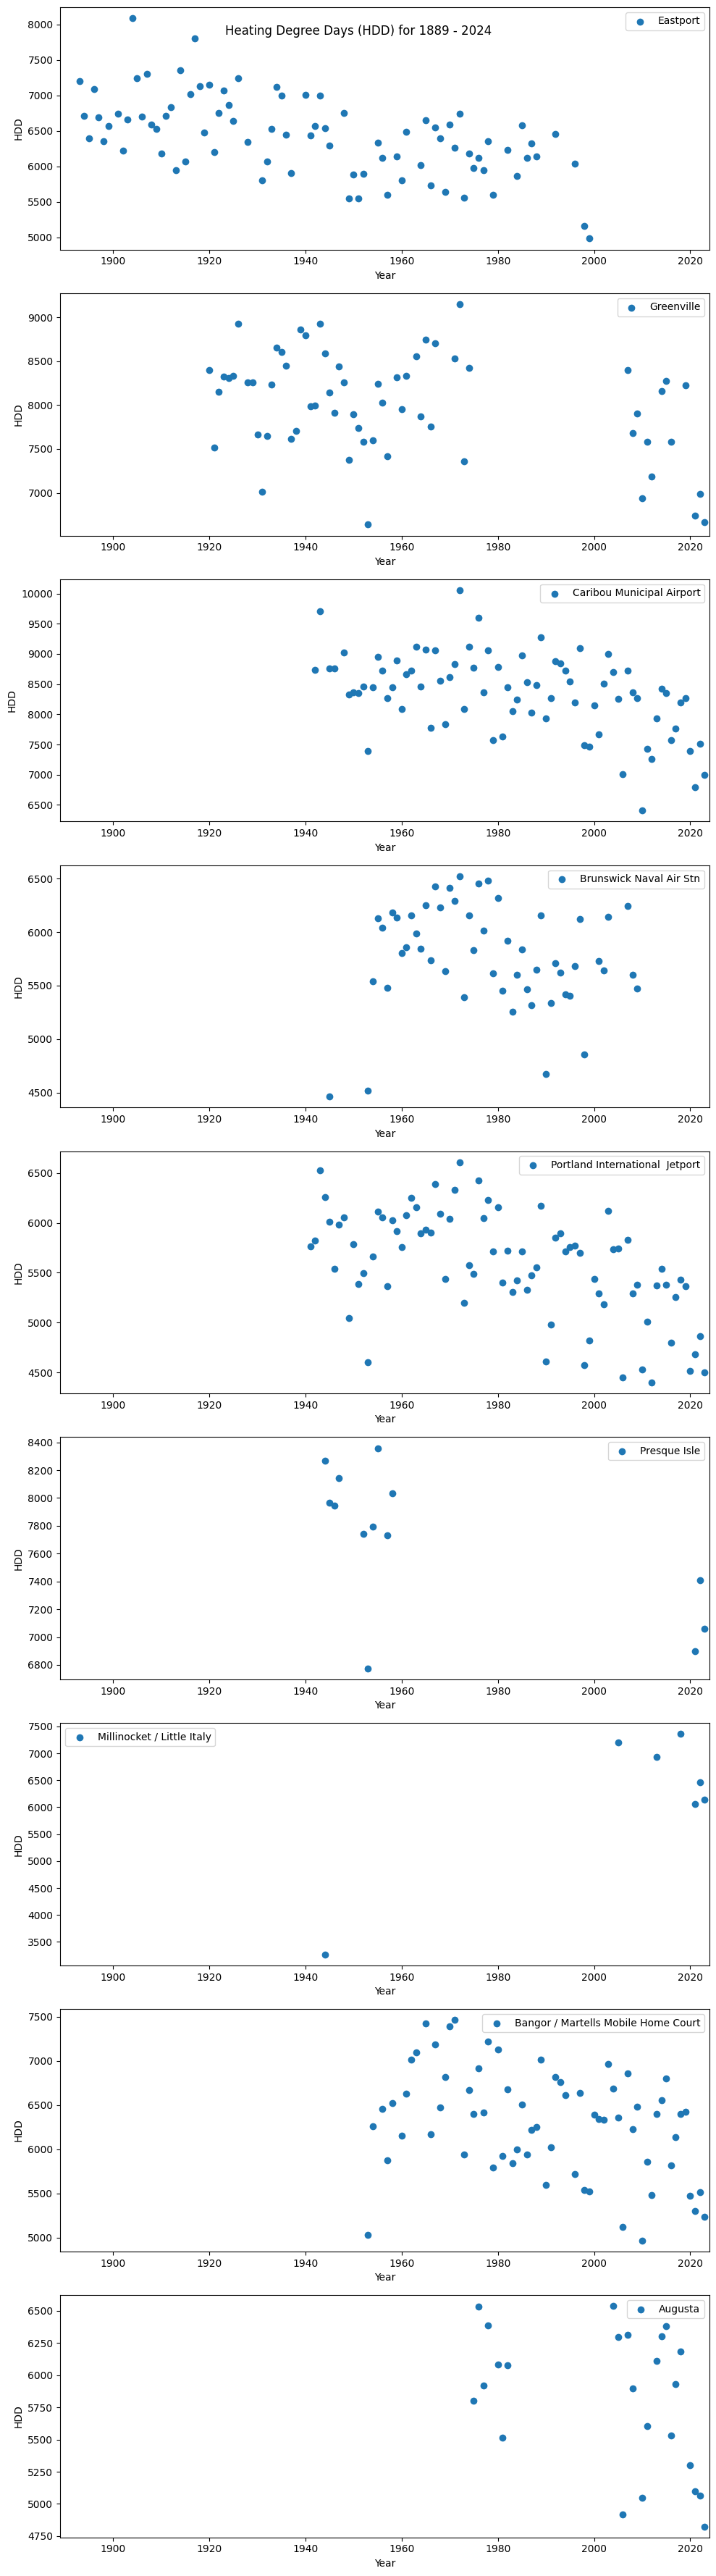

In [49]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def annual_hdd_for_station(
    station: str,
    year: int
):
    data = meteostat.Daily(
        start=datetime(year,1,1),
        end= datetime(year, 12, 31),
        loc= station
    ).fetch()
    
    # Only run the calculation if we have a complete annual dataset
    if not (data.shape[0] == 365 or data.shape[0] == 366):
        return None

    # Average daily temperature can be estimated as average of the daily min and max
    # We will overwrite any recorded average with this value for consistency
    data["tavg"] = data["tmax"] + data["tmin"] / 2.
    
    # HDD requires conversion to degrees F
    data["tavg_f"] = data["tavg"]*1.8 + 32.
    data["hdd"] = np.where(data["tavg_f"] <=65., 65. - data["tavg_f"], 0.)
    
    return data["hdd"].sum()

annual_hdd = pd.DataFrame(index=list(range(start_year, end_year)))

for station, df in maine_stations.iterrows():
    annual_hdd[station] = [annual_hdd_for_station(station, year) for year in range(start_year, end_year)]
    annual_hdd[station] = annual_hdd[station].replace(0, None)
    
# Plot all data in sigle plot
for col in annual_hdd.columns.tolist():
    plt.scatter(annual_hdd.index.to_numpy(), annual_hdd[col].to_numpy(), label=maine_stations.loc[col]["name"])
    plt.xlabel("Year")
    plt.ylabel("HDD")
    plt.legend(bbox_to_anchor=(1.65, 0.5), loc='center right')
    
plt.title(f"Heating Degree Days (HDD) for {start_year} - {end_year}")
plt.show()

# Plot each series
fig, axes = plt.subplots(nrows= len(annual_hdd.columns), figsize=(10, 4* len(annual_hdd.columns)))
for i, col in enumerate(annual_hdd.columns):
    ax = axes[i]
    ax.scatter(annual_hdd.index.to_numpy(), annual_hdd[col].to_numpy(), label=maine_stations.loc[col]["name"])
    ax.set_xlabel("Year")
    ax.set_xlim(start_year, end_year)
    ax.set_ylabel("HDD")
    ax.legend()

# Adjust layout and display the plot
fig.suptitle(f"Heating Degree Days (HDD) for {start_year} - {end_year}")
plt.tight_layout()
plt.show()
annual_hdd.to_csv("simple_hdd.csv")

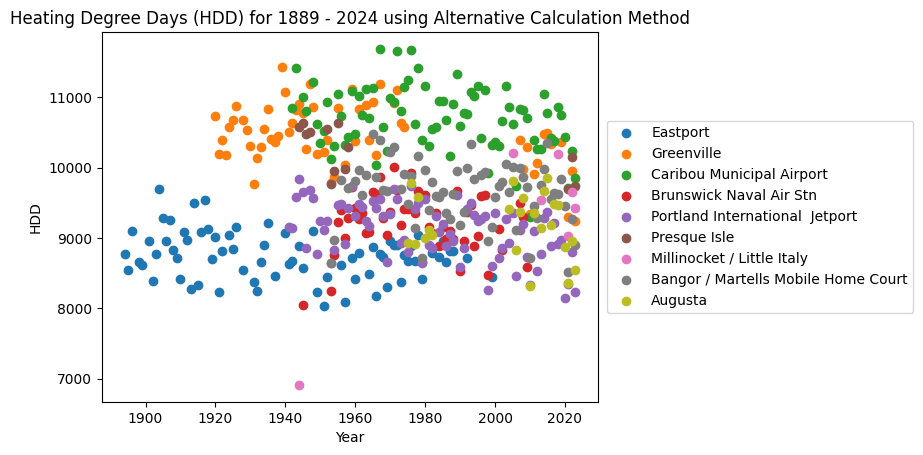

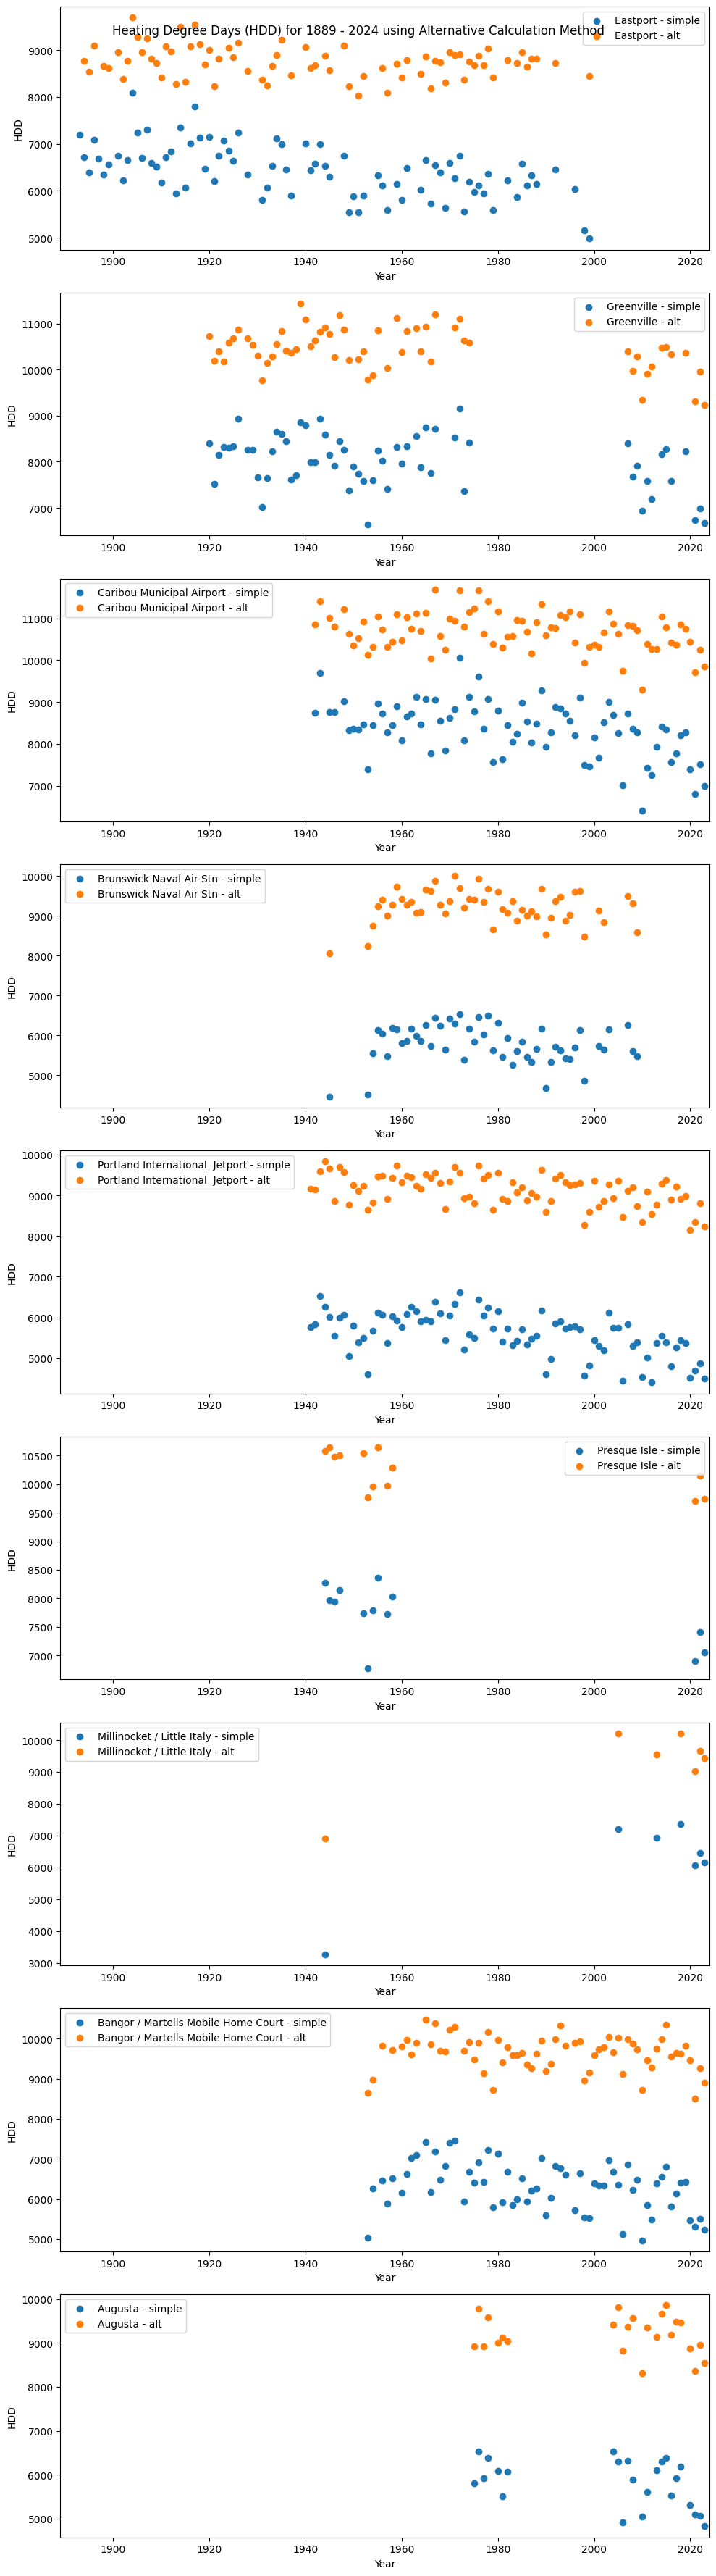

In [50]:
import numpy as np


def annual_alt_hdd_for_station(
    station: str,
    year: int,
    tbase_f: float = 65.
):
    """
    Uses an alternative HDD calculation https://www.vesma.com/ddd/ddcalcs.htm for maritime climates designed to capture heating requirements throughout the year. I.E. a cold morning in June
    """
    data = meteostat.Daily(
        start=datetime(year,1,1),
        end= datetime(year, 12, 31),
        loc= station
    ).fetch()
    
    # Only run the calculation if we have a complete annual dataset
    if not (data.shape[0] == 365 or data.shape[0] == 366):
        return None

    hdd = 0
    for _, row in data.iterrows():
        tmin_f = np.float16(row["tmin"])*1.8 + 32.
        tmax_f = np.float16(row["tmax"])*1.8 + 32.
        if tmin_f > tbase_f: 
            continue
        elif (np.add(tmax_f, tmin_f)/2.) > tbase_f:
            daily_hdd = np.divide(np.add(tbase_f, tmin_f), 4.) #(Tbase-Tmin)/4
            hdd = np.add(hdd, daily_hdd)
        elif (tmax_f >= tbase_f):
            daily_hdd = np.subtract(np.divide(np.subtract(tbase_f, tmin_f), 2.), np.divide(np.subtract(tmax_f, tbase_f), 4.)) #(Tbase-Tmin)/2-(Tmax-Tbase)/4
            hdd = np.add(hdd, daily_hdd)
        elif (tmax_f < tbase_f):
            daily_hdd = np.subtract(tbase_f, np.divide(np.add(tmax_f, tmin_f), 2.)) #typical HDD calculation: Tbase-(Tmax+Tmin)/2
            hdd = np.add(hdd, daily_hdd)
    return hdd


alt_hdd = pd.DataFrame(index=list(range(start_year, end_year)))

for station, df in maine_stations.iterrows():
    alt_hdd[station] = [annual_alt_hdd_for_station(station, year) for year in range(start_year, end_year)]
    alt_hdd[station] = alt_hdd[station].replace(0, None)
    
for col in alt_hdd.columns.tolist():
    plt.scatter(alt_hdd.index.to_numpy(), alt_hdd[col].to_numpy(), label=maine_stations.loc[col]["name"])
    plt.xlabel("Year")
    plt.ylabel("HDD")
    plt.legend(bbox_to_anchor=(1.65, 0.5), loc='center right')
    
plt.title(f"Heating Degree Days (HDD) for {start_year} - {end_year} using Alternative Calculation Method")
plt.show()

# Plot each series
fig, axes = plt.subplots(nrows= len(annual_hdd.columns), figsize=(10, 4* len(annual_hdd.columns)))
for i, col in enumerate(annual_hdd.columns):
    ax = axes[i]
    ax.scatter(annual_hdd.index.to_numpy(), annual_hdd[col].to_numpy(), label=f'{maine_stations.loc[col]["name"]} - simple')
    ax.scatter(alt_hdd.index.to_numpy(), alt_hdd[col].to_numpy(), label=f'{maine_stations.loc[col]["name"]} - alt')
    ax.set_xlabel("Year")
    ax.set_xlim(start_year, end_year)
    ax.set_ylabel("HDD")
    ax.legend()

# Adjust layout and display the plot
fig.suptitle(f"Heating Degree Days (HDD) for {start_year} - {end_year} using Alternative Calculation Method")
plt.tight_layout()
plt.show()


alt_hdd.to_csv("alt_hdd.csv")